In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
jax.config.update("jax_enable_x64", True)
import numpy as np

True


Initialisation of a twin experiment. 

In [2]:
signal_params = ConfigDict(KDV_params_2_SALT)
ensemble_params = ConfigDict(KDV_params_2_SALT)
ensemble_params.update(E=1,P=32,stochastic_advection_basis='constant')
ensemble_params.update(E=128,P=32,stochastic_advection_basis='constant')

Now we specify the models, by calling the class.

In [3]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
ensemble_model = ETD_KT_CM_JAX_Vectorised(ensemble_params)

initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_ensemble = initial_condition(ensemble_model.x, ensemble_params.E, ensemble_params.initial_condition)

available_resamplers = ", ".join(resamplers.keys())
print(available_resamplers)

multinomial, systematic, no_resampling, default


In [4]:
observation_spatial_frequency = 8
observation_locations = np.arange(0,signal_model.x.shape[0],observation_spatial_frequency)
observation_noise = 0.01
number_of_observations_time = int(ensemble_model.nt/2)
observation_temporal_frequency = int(ensemble_model.nt/number_of_observations_time)

print(observation_locations)
print(observation_temporal_frequency)
pf_systematic = ParticleFilter(
    n_particles = ensemble_params.E,
    n_steps = observation_temporal_frequency,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model,
    signal_model = signal_model,
    sigma = observation_noise,
    seed = 1,
    resampling="default",#'default',
    observation_locations = observation_locations,
)

[  0   8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136
 144 152 160 168 176 184 192 200 208 216 224 232 240 248]
2


In [5]:
da_steps = number_of_observations_time
final, all = pf_systematic.run(initial_ensemble, initial_signal, da_steps) #the final input is scan length? 

Put in the initial condition.

In [6]:
particles =jnp.concatenate([initial_ensemble[None,...], all[0]], axis=0)
signal = jnp.concatenate([initial_signal[None,...], all[1]], axis=0)
observations = jnp.concatenate([initial_signal[None,...], all[2]], axis=0)
observations = all[2][:,:, observation_locations]
print(observations.shape)
print(particles.shape)

(2000, 1, 32)
(2001, 128, 256)


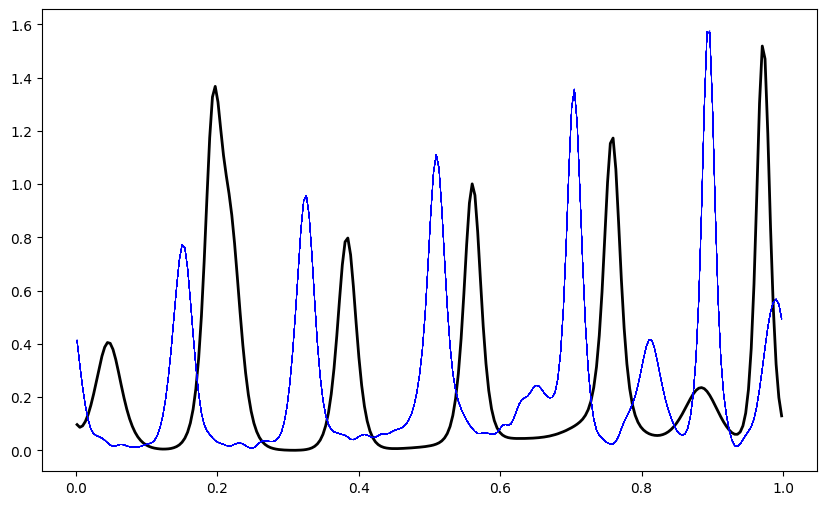

interactive(children=(IntSlider(value=1000, description='da_step', max=2000), Output()), _dom_classes=('widget…

<function __main__.plot(da_step)>

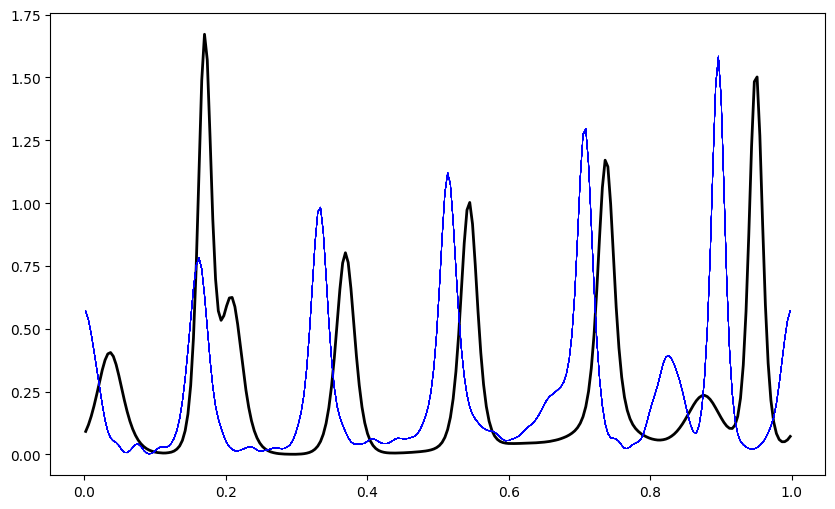

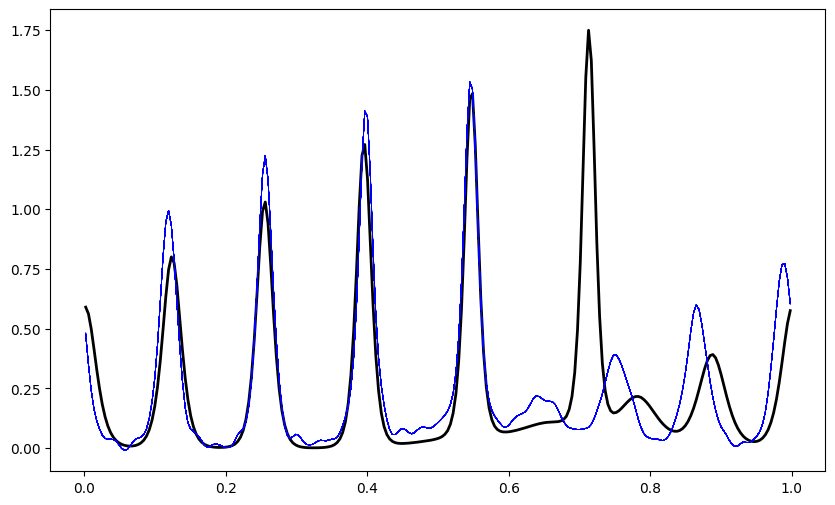

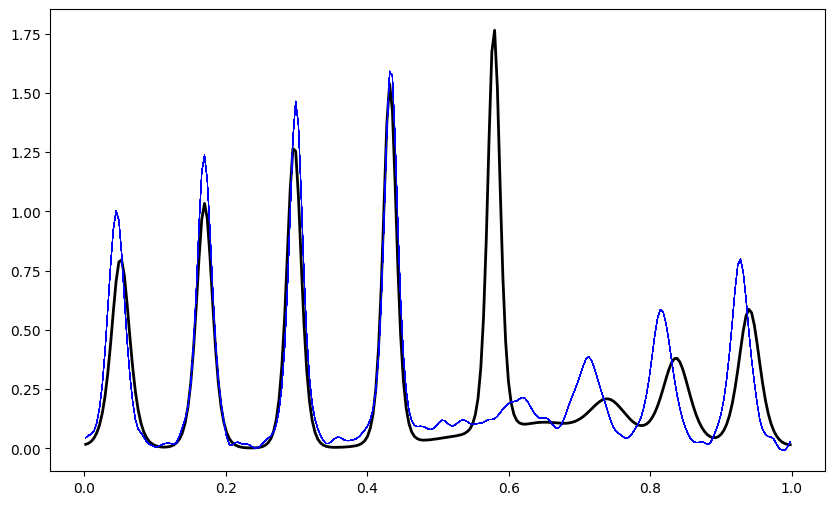

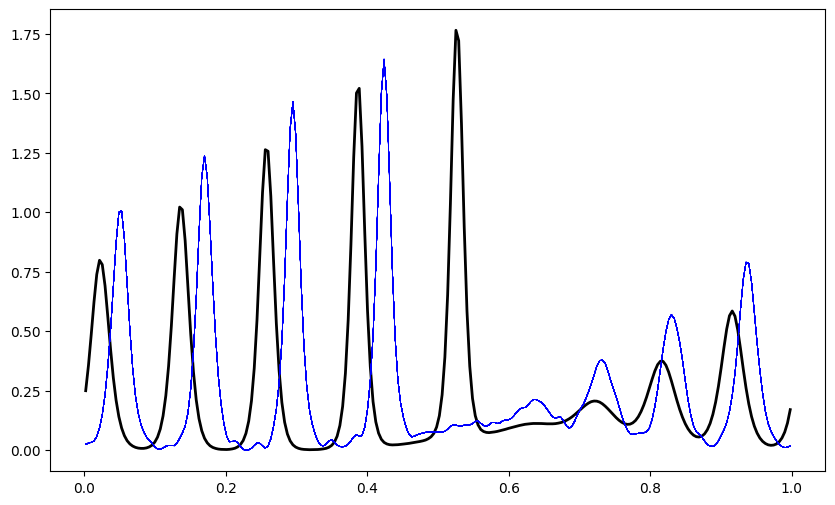

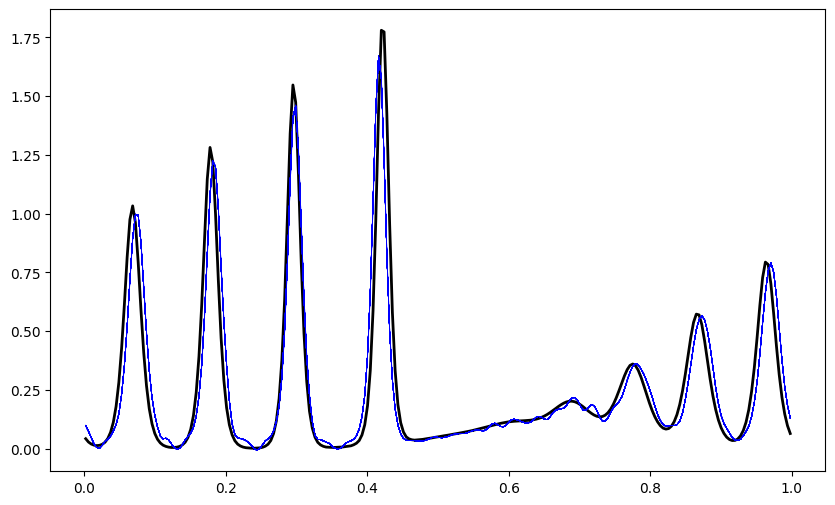

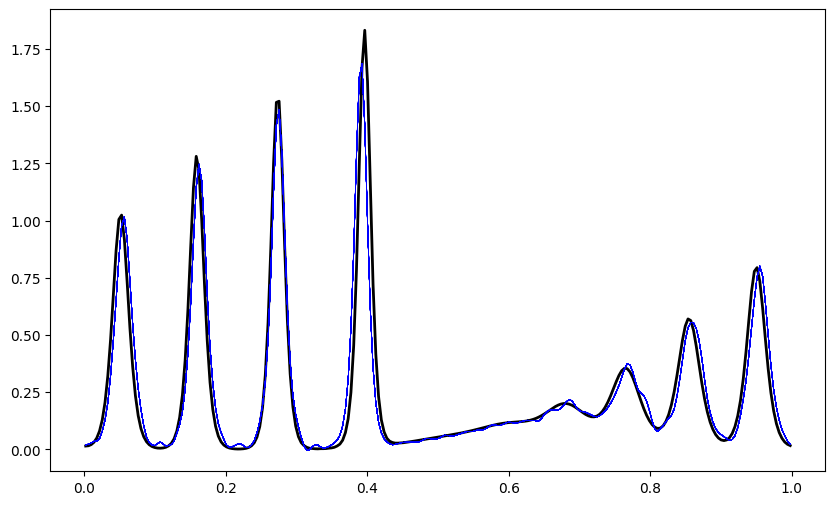

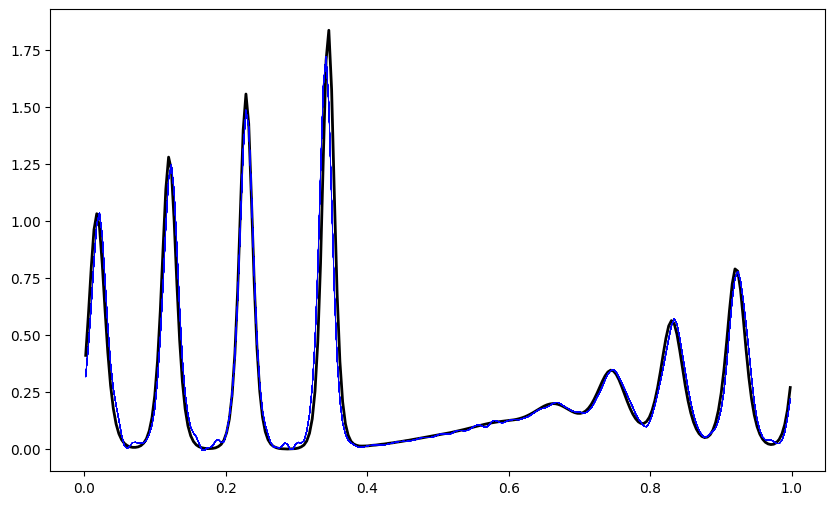

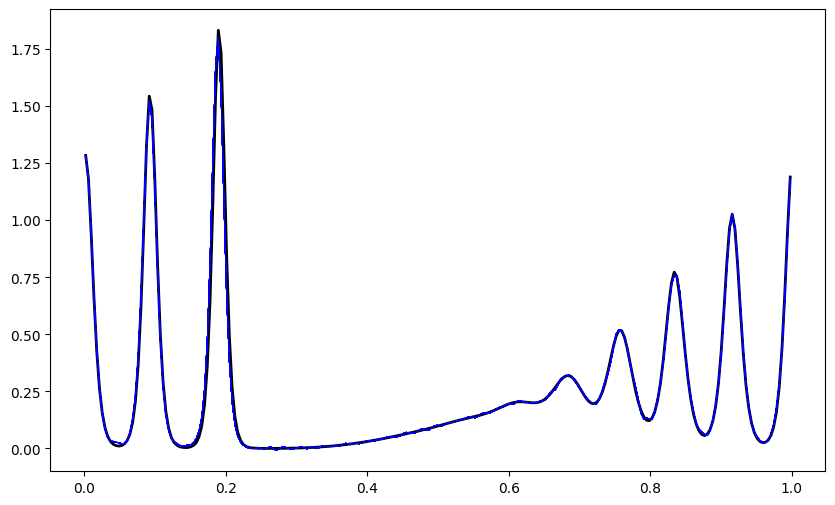

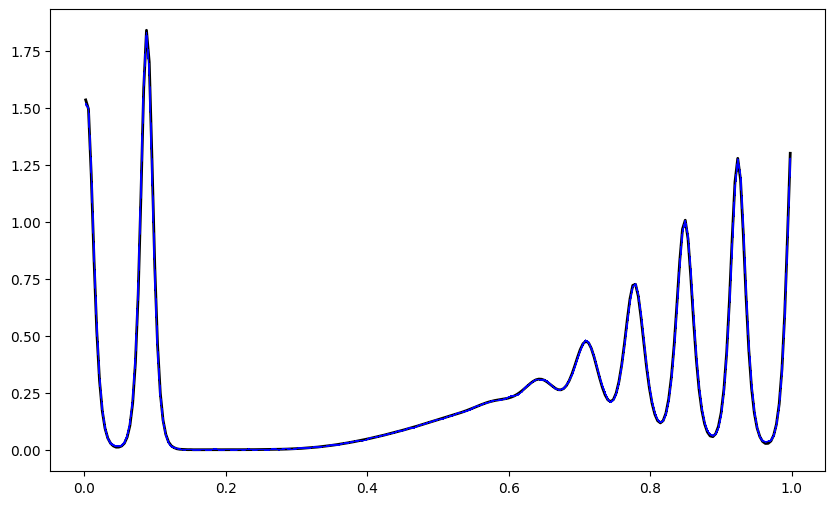

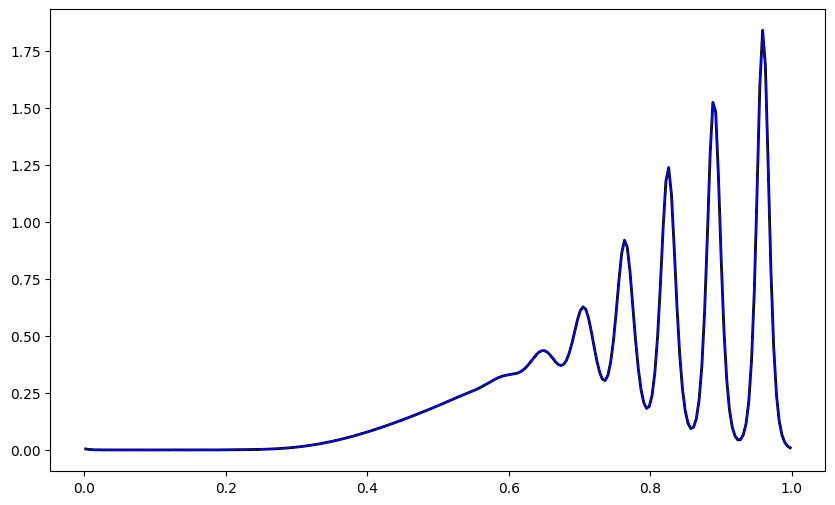

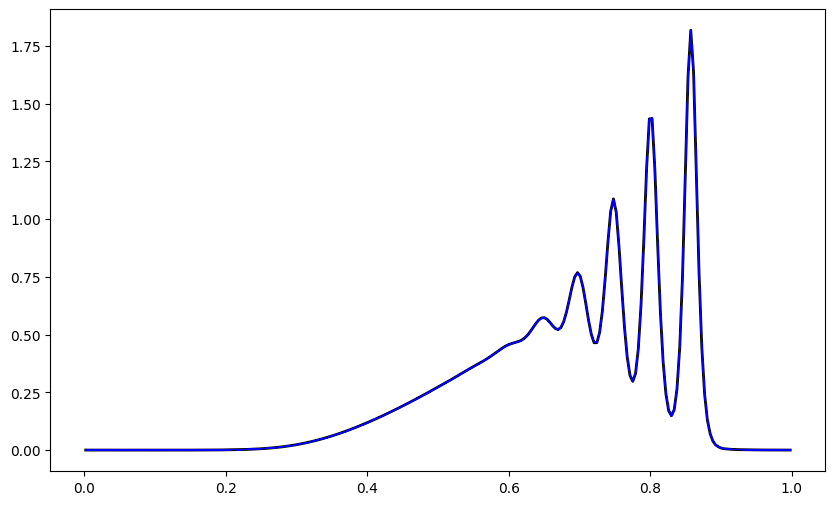

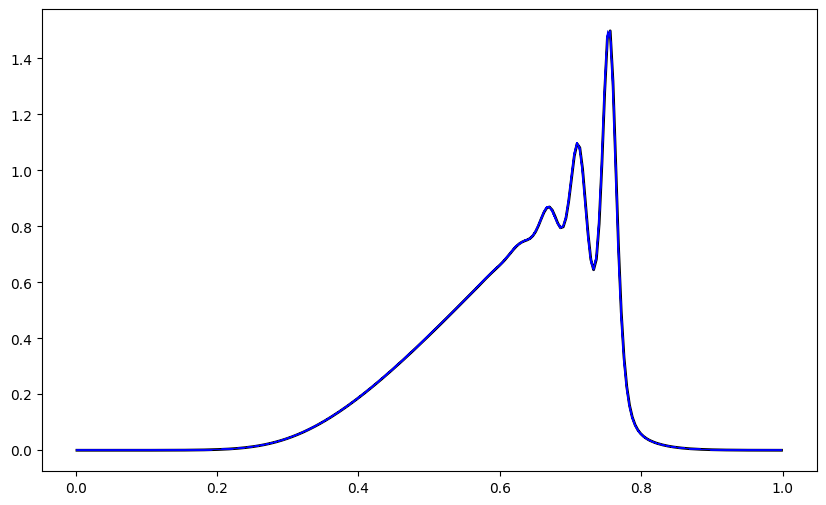

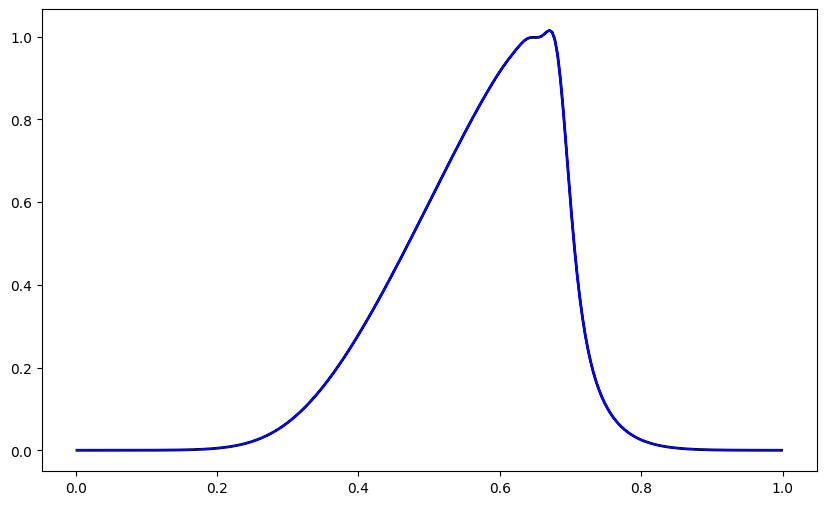

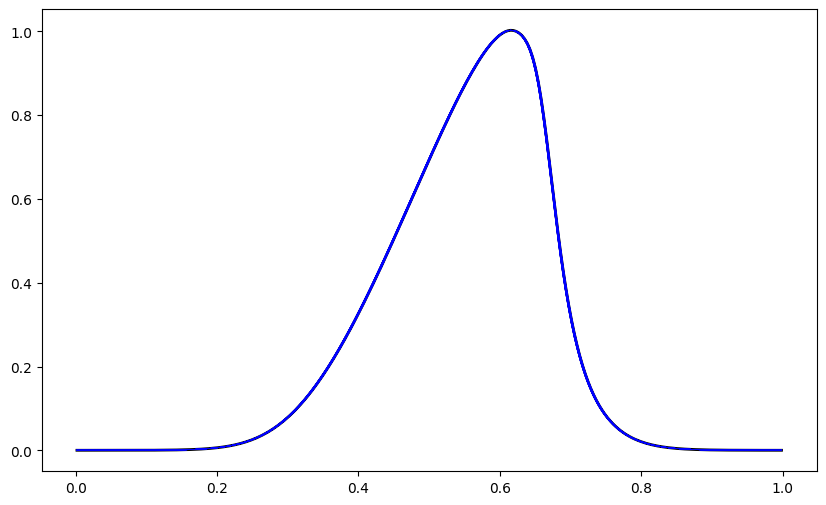

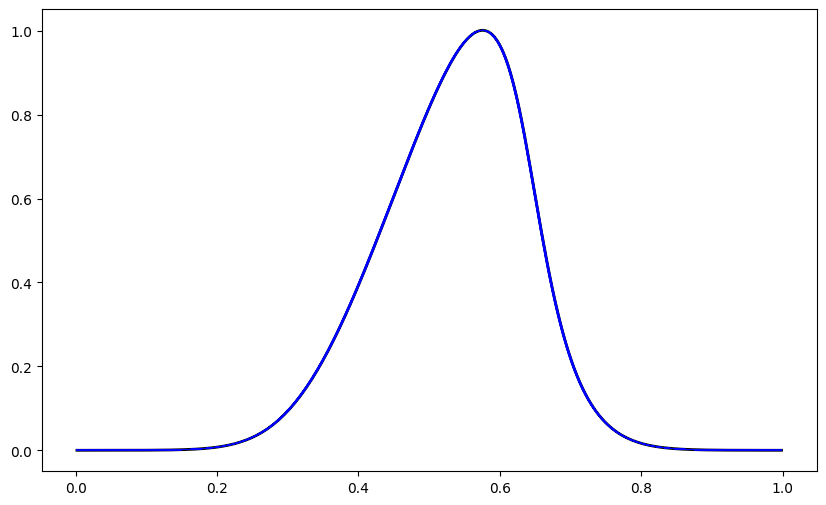

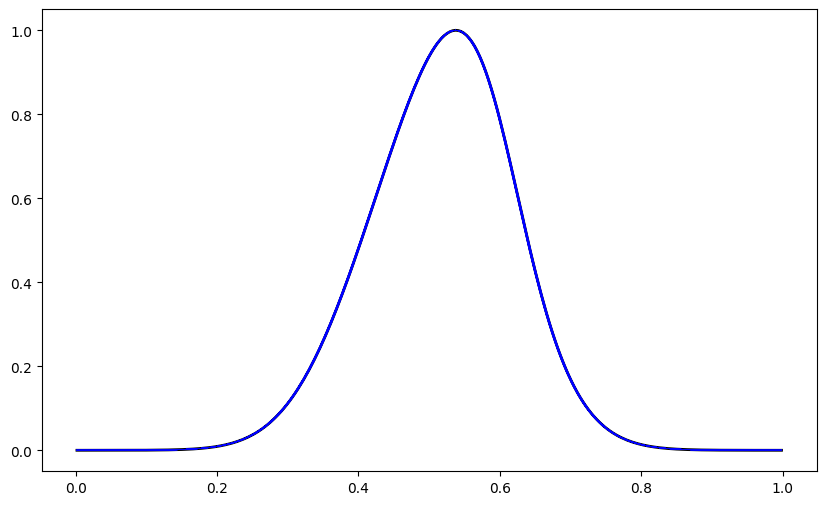

In [7]:
def plot(da_step):
    plt.figure(figsize=(10, 6))
    plt.plot(signal_model.x, signal[da_step, 0, :], color='k', label='Signal', linewidth=2)
    plt.plot(signal_model.x, particles[da_step, 0, :].T, color='b', label='Particles', linewidth=0.5, alpha=0.5)

    plt.plot(signal_model.x, particles[da_step, :, :].T, color='b', linewidth=0.5, alpha=0.5)
    if da_step > 0:
        plt.scatter(signal_model.x[observation_locations], observations[da_step - 1, 0, 0], color='r', label='Observations', zorder=5)

        plt.scatter(signal_model.x[observation_locations], observations[da_step - 1, 0, :], color='r', zorder=5)
    plt.xlabel('Spatial Domain', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    plt.title(f'Data Assimilation Step {da_step}', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    #plt.tight_layout()
    plt.show()
interact(plot, da_step=(0, da_steps))